In [1]:
from pyDeepInsight import ImageTransformer, LogScaler
import pandas as pd
import numpy as np
import pickle
import anndata
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing
from timeit import default_timer as timer

In [2]:
reference = anndata.read_h5ad("reference_sct.h5ad")
#Scaling
min_max_scaler = preprocessing.MinMaxScaler()
scaled = pd.DataFrame(reference.X).transpose()
scaled = min_max_scaler.fit_transform(scaled)
scaled = pd.DataFrame(scaled).transpose()
scaled.index = reference.obs.index.values
scaled.columns = reference.var.index.values

In [3]:
#Get cell-type information from initial reference dataset
ref = anndata.read_h5ad("reference.h5ad")
obs = ref.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["celltype.l2"]
tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []
test_ls = []
#Split dataset into training dataset, validation dataset and test dataset by 90:5:5
for tag in tags:
    df = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)
    train_part = df.sample(frac=0.90)[0].tolist()
    df = df[~df[0].isin(train_part)]
    val_part = df.sample(frac=0.50)[0].tolist()
    df = df[~df[0].isin(val_part)]
    test_part = df.sample(frac=1.0)[0].tolist()
    train_ls = train_ls + train_part
    val_ls = val_ls + val_part
    test_ls = test_ls + test_part
    
train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
test_rna = scaled.loc[test_ls]

train_rna

,HES4,ISG15,TNFRSF18,TNFRSF4,MXRA8,MIB2,MMP23B,PLCH2,SMIM1,GPR153,...,IGHV3-66,IGFL2,IGKV2-29,NXF3,IGHV4-31,IGHV3-73,IGLV9-49,IGKV2-24,IGHV2-26,celltype_l2
E2L7_TGCTTGCCACTCAGAT,0.264730,0.247774,0.266514,0.270030,0.277327,0.265338,0.271252,0.274576,0.275472,0.276636,...,0.279532,0.279510,0.279606,0.279418,0.279553,0.279333,0.279466,0.279606,0.279495,CD14 Mono
E2L7_ATGAGTCTCACCATCC,0.215910,0.409949,0.217865,0.219973,0.228154,0.214866,0.221885,0.225478,0.225921,0.227429,...,0.230295,0.230223,0.230356,0.230196,0.230297,0.230104,0.230247,0.230357,0.230242,CD14 Mono
E2L4_GAGGCCTCAAGTTGGG,0.061196,0.118927,0.061731,0.061740,0.064864,0.060217,0.062709,0.064029,0.063962,0.064612,...,0.065607,0.065546,0.065625,0.065575,0.065597,0.065533,0.065598,0.065627,0.065575,CD14 Mono
E2L4_TCAAGCAAGGAAAGTG,0.215149,0.217235,0.217578,0.219811,0.228349,0.213773,0.221799,0.225534,0.225993,0.227584,...,0.230436,0.230390,0.230490,0.230348,0.230444,0.230268,0.230390,0.230491,0.230397,CD14 Mono
L3_GAAGTAAAGCGGATCA,0.070179,0.081001,0.070988,0.070557,0.074506,0.089765,0.071913,0.073543,0.073318,0.074196,...,0.075310,0.075232,0.075324,0.075283,0.075294,0.075236,0.075307,0.075326,0.075272,CD14 Mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L1_CTCCCTCTCGTCTAAG,0.311864,0.408536,0.313003,0.310231,0.320590,0.306481,0.314282,0.318473,0.317413,0.319836,...,0.322750,0.322437,0.322790,0.322668,0.322676,0.322510,0.322754,0.322797,0.322604,ILC
L5_TGTCCCAGTCAAGTTC,0.211015,0.199117,0.538267,0.211900,0.218188,0.208844,0.213911,0.216553,0.216353,0.217685,...,0.219644,0.219516,0.219678,0.219583,0.219621,0.219500,0.219629,0.219681,0.219578,ILC
L2_CGTTGGGCACATGGTT,0.222754,0.284298,0.352923,0.223515,0.229757,0.220702,0.225514,0.228140,0.227946,0.229259,...,0.231244,0.231109,0.231280,0.231179,0.231219,0.231091,0.231228,0.231283,0.231174,ILC
E2L2_CACTAAGAGTTCAACC,0.157215,0.151252,0.157934,0.161260,0.162979,0.159501,0.160808,0.344220,0.162731,0.162745,...,0.163862,0.163937,0.163904,0.163803,0.163898,0.163790,0.163813,0.163902,0.163878,ILC


In [4]:
#Store cell-type information in this step for further training
pd.DataFrame(train_rna["celltype_l2"]).to_csv("./pretrained_0/trainy_pre.csv")
pd.DataFrame(val_rna["celltype_l2"]).to_csv("./pretrained_0/valy_pre.csv")
pd.DataFrame(test_rna["celltype_l2"]).to_csv("./pretrained_0/testy_pre.csv")

In [5]:
start = timer()
rna_list = np.array_split(train_rna, 4)
#Split the dataset to avoid memory problems
rna1 = rna_list[0]
img_1 = (np.resize(rna1.iloc[:, :-1]*300, (len(rna1.index.tolist()),300,300,3))).astype(np.uint8)
rna2 = rna_list[1]
img_2 = (np.resize(rna2.iloc[:, :-1]*300, (len(rna2.index.tolist()),300,300,3))).astype(np.uint8)
rna3 = rna_list[2]
img_3 = (np.resize(rna3.iloc[:, :-1]*300, (len(rna3.index.tolist()),300,300,3))).astype(np.uint8)
rna4 = rna_list[3]
img_4 = (np.resize(rna4.iloc[:, :-1]*300, (len(rna4.index.tolist()),300,300,3))).astype(np.uint8)

train_img = np.concatenate((img_1, img_2, img_3, img_4), axis=0)
val_img = (np.resize(val_rna.iloc[:, :-1]*300, (len(val_rna.index.tolist()),300,300,3))).astype(np.uint8)
test_img = (np.resize(test_rna.iloc[:, :-1]*300, (len(test_rna.index.tolist()),300,300,3))).astype(np.uint8)
end = timer()
print(end - start)

405.2990577539895


In [6]:
train_img[1]

array([[[ 31,  40,  32],
        [ 32,  33,  31],
        [ 32,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  29,  31],
        [ 32,  32,  33]],

       [[ 32,  33,  32],
        [ 32,  33,  33],
        [ 34,  43,  33],
        ...,
        [ 34,  33,  44],
        [ 34,  33,  33],
        [ 33,  31,  32]],

       [[ 33,  38,  33],
        [ 33,  32,  33],
        [ 29,  33,  33],
        ...,
        [ 30,  33,  33],
        [ 33,  28,  32],
        [ 33,  31,  33]],

       ...,

       [[ 82,  83,  83],
        [ 82,  82,  83],
        [ 76,  91,  81],
        ...,
        [ 83,  82, 101],
        [ 83,  81,  82],
        [104,  82,  83]],

       [[ 82,  83,  81],
        [ 71,  80,  82],
        [ 82,  83,  78],
        ...,
        [ 81,  80,  75],
        [ 81,  82,  82],
        [ 91,  82,  76]],

       [[ 81, 105,  81],
        [ 83,  79,  82],
        [ 82,  82,  72],
        ...,
        [ 83,  83,  83],
        [ 83,  83,  83],
        [ 83,  83,  83]]

In [7]:
train_img.shape

(145336, 300, 300, 3)

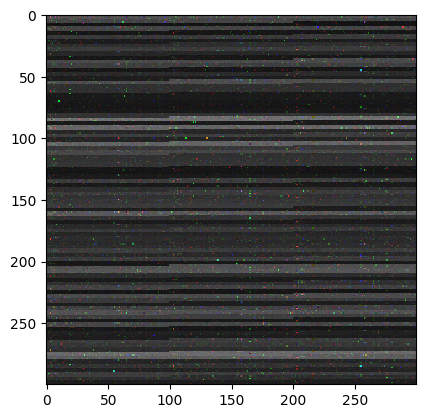

In [8]:
from matplotlib import pyplot as plt
plt.imshow(train_img[0], interpolation='nearest')
plt.show()

In [9]:
#Store processed images in npy format
path1 = '/Usersdata/shangru/docker/pretrained_0/train_pre.npy'
path2 = '/Usersdata/shangru/docker/pretrained_0/val_pre.npy'
path3 = '/Usersdata/shangru/docker/pretrained_0/test_pre.npy'

np.save(path1, train_img)
np.save(path2, val_img)
np.save(path3, test_img)